# Hands-on Workshop: Circulation Analytics + Viz Clinic

We will:
- load datasets
- compute KPIs
- segment results
- produce 3 charts
- practice "bad → better → action" framing


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)

In [8]:
txns = pd.read_csv("../data/txns.csv", parse_dates=["checkout_dt","due_dt","return_dt"])
holds = pd.read_csv("../data/holds.csv", parse_dates=["request_dt","fulfill_dt"])

txns.head(), holds.head()


(     txn_id checkout_dt  item_id patron_id checkout_location  \
 0  T0000001  2025-07-08  I002093   P001137              Main   
 1  T0000002  2025-01-22  I000668   P000309              Main   
 2  T0000003  2024-10-02  I004834   P002140              Main   
 3  T0000004  2025-07-22  I000037   P000460              Main   
 4  T0000005  2025-03-11  I005825   P000665              Main   
 
    loan_policy_days collection   subject     due_dt patron_group risk_profile  \
 0                28       Book      STEM 2025-08-05        Staff          low   
 1                28       Book  Business 2025-02-19    Undergrad       medium   
 2                28       Book       HSS 2024-10-30         Grad       medium   
 3                28       Book  Business 2025-08-19    Undergrad          low   
 4                28       Book  Business 2025-04-08    Undergrad       medium   
 
    renewal_count  return_dt  is_returned  is_late  late_days  
 0              0 2025-08-03         True    False

In [9]:
txns["is_returned"] = txns["return_dt"].notna()
txns["is_late"] = txns["is_returned"] & (txns["return_dt"] > txns["due_dt"])
txns["late_days"] = np.where(txns["is_late"], (txns["return_dt"] - txns["due_dt"]).dt.days, 0)

fulfilled = holds[holds["status"].eq("fulfilled")].copy()


## Part A — Executive KPIs


In [10]:
kpi = pd.Series({
    "transactions": len(txns),
    "unique_patrons": txns["patron_id"].nunique(),
    "late_rate": float(txns["is_late"].mean()),
    "renew_rate": float((txns["renewal_count"] > 0).mean()),
    "not_returned_rate": float((~txns["is_returned"]).mean()),
})
kpi


transactions         20000.00000
unique_patrons        2996.00000
late_rate                0.12490
renew_rate               0.59525
not_returned_rate        0.02090
dtype: float64

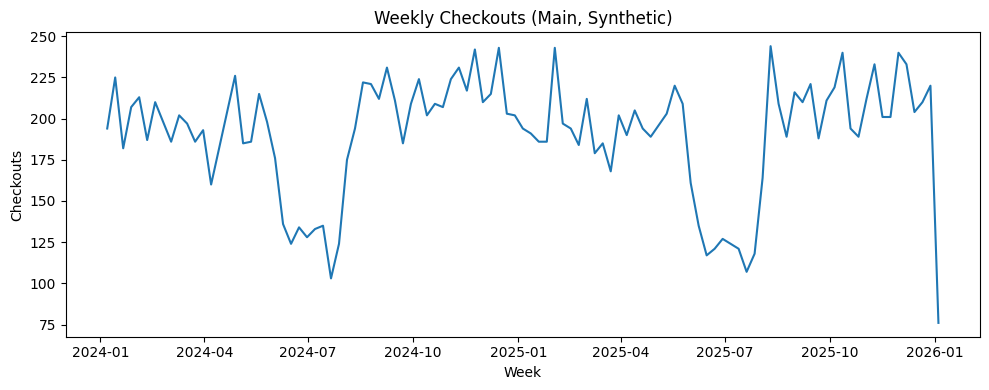

In [11]:
weekly = (
    txns.groupby(pd.Grouper(key="checkout_dt", freq="W"))
        .size().rename("checkouts")
        .reset_index()
)

plt.figure()
plt.plot(weekly["checkout_dt"], weekly["checkouts"])
plt.title("Weekly Checkouts (Main, Synthetic)")
plt.xlabel("Week")
plt.ylabel("Checkouts")
plt.tight_layout()
plt.show()


## Part B — Holds: Average vs Quantiles (Viz Clinic)
Exercise: Why is average misleading here?


In [12]:
avg_wait = fulfilled["wait_days"].mean()
avg_wait


5.530317212688507

In [13]:
q = fulfilled["wait_days"].quantile([0.5, 0.9, 0.95]).rename({0.5:"median",0.9:"p90",0.95:"p95"})
q["max"] = fulfilled["wait_days"].max()
q


median     5.1
p90        8.6
p95       10.1
max       19.9
Name: wait_days, dtype: float64

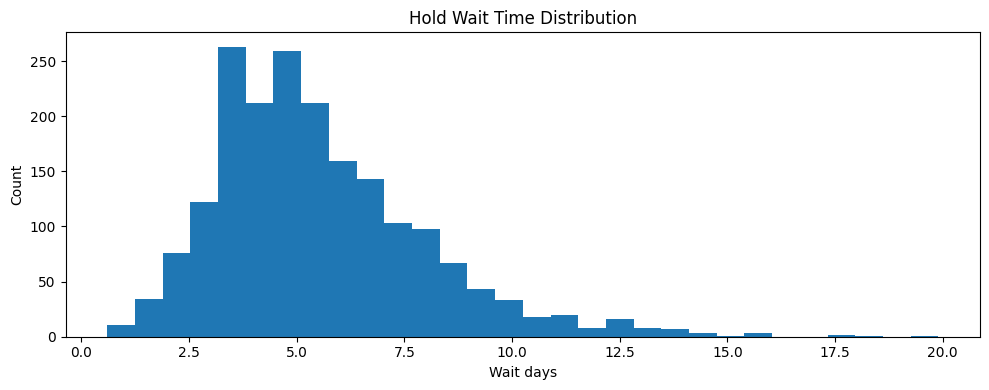

In [14]:
plt.figure()
plt.hist(fulfilled["wait_days"], bins=30)
plt.title("Hold Wait Time Distribution")
plt.xlabel("Wait days")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Part C — Late Returns: Segment & Prioritize
Exercise: late_rate is not enough; prioritize by impact.


In [15]:
late_seg = (txns
    .groupby(["patron_group","collection"])
    .agg(transactions=("txn_id","count"), late_rate=("is_late","mean"))
    .reset_index()
)
late_seg["risk_score"] = late_seg["transactions"] * late_seg["late_rate"]
late_seg.sort_values("risk_score", ascending=False).head(10)


,patron_group,collection,transactions,late_rate,risk_score
16,Undergrad,Book,8236,0.122632,1010.0
8,Grad,Book,3304,0.126513,418.0
4,Faculty,Book,1574,0.118170,186.0
0,Community,Book,1036,0.164093,170.0
12,Staff,Book,1502,0.111851,168.0
18,Undergrad,DVD,1029,0.113703,117.0
17,Undergrad,CourseReserve,849,0.128386,109.0
10,Grad,DVD,367,0.158038,58.0
19,Undergrad,Laptop,389,0.100257,39.0
9,Grad,CourseReserve,338,0.094675,32.0


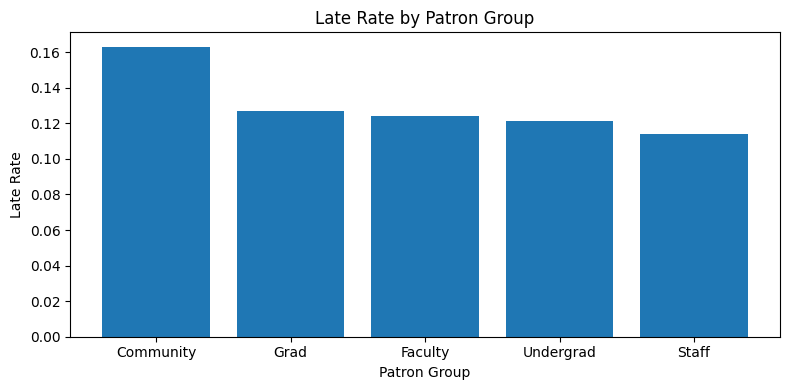

In [16]:
by_group = (txns
    .groupby("patron_group")
    .agg(late_rate=("is_late","mean"), transactions=("txn_id","count"))
    .reset_index()
).sort_values("late_rate", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(by_group["patron_group"], by_group["late_rate"])
plt.title("Late Rate by Patron Group")
plt.xlabel("Patron Group")
plt.ylabel("Late Rate")
plt.tight_layout()
plt.show()


## Exercises (5–10 min)

1) Compute `p95` wait time for semester_peak vs summer_offpeak  
2) Find the top 3 segments by `risk_score` with `transactions >= 80`  
3) Suggest one operational improvement based on the results


In [17]:
git remote add origin https://github.com/LiMi686/library-circulation-mvp.git
git branch -M main
git push -u origin main

SyntaxError: invalid syntax (1157097454.py, line 1)